# 1. Importing libraries and datasets 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import os
import tensorflow as tf
from sklearn.manifold import TSNE
from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
pyLDAvis.enable_notebook()

In [3]:
def wordcloud_cluster(data_frame,columns):
    temp_df = list(data_frame[columns])
    cloud = " ".join(temp_df)
    stop_words = set(stopwords.words("english"))
    wordcloud = WordCloud(width = 1600, height = 1200, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    return plt
    

In [4]:
def visualizing_topic_cluster(model,stop_len,feat_name):
    topic={}
    for index,topix in enumerate(model.components_):
        topic[index]= [feat_name[i] for i in topix.argsort()[:-stop_len-1:-1]]
    
    return topic

In [6]:
def rmse_calculation(x,y):
    x,y =x,y
    error=[]
    len_y =len(y)
    for i in range(len_y):
        error.append(np.sqrt(np.power((np.array(x)-np.array(y[i])),2).sum()/len_y))
    return error

In [7]:
def reccomendation(df,paper_id,col):
    paper_1 = df[(df['id']==paper_id)]
    dominant_topic = int(paper_1['Major_topic'])
    keyword =paper_1['keyword']
    paper_2 =df
    paper_2 = paper_2.drop(paper_1.index)
    x= paper_1[columns].values.tolist()
    y= paper_2[columns].values.tolist()
    error = np.round(rmse_calculation(x,y),6)
    paper_2['error'] = error
    paper_2 = paper_2[['id','title','error','Major_topic']].sort_values('error').head(10)
    title = list(paper_2['title'])
    error = list(paper_2['error'])
    topic_actual =list(paper_2['Major_topic'])
    topic_pred  = list([int(dominant_topic) for i in range(len(title))])
    print(" The title  of selected paper is  :  {}".format(list(paper_1.title)[0]))
    print(" Major Topic --- {}".format(dominant_topic))
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The  keywords which is highlighted in this topic are as follows : ")
    [print(i,) for i in paper_1['keyword']]
    print("------------------------------------------------------------------------------------------------------------------------")
    print(" The Recommended topic are as follows: ")
    [print(i+1,"...",title[i],"---","\n","     Error  is ","...",error[i]) for i in range(10)]
    print("------------------------------------------------------------------------------------------------------------------------")

In [8]:
def eval_metrics(df,col):
    topic_actual=[]
    topic_pred =[]
    for i in range(len(df)):
        paper_1 = df.iloc[i]
        dominant_topic = int(paper_1['Major_topic'])
        related_topic_no = len(df[(df['Major_topic']==dominant_topic)])-1
        paper_2 = df[(df['id']!=paper_1['id'])]
        x= paper_1[col].values.tolist()
        y= paper_2[col].values.tolist()
        error = np.round(rmse_calculation(x,y),6)
        paper_2['error'] = error
        paper_2 = paper_2[['id','title','error','Major_topic']].sort_values('error').head(related_topic_no)
        topic_actual = topic_actual+paper_2['Major_topic'].values.tolist()
        topic_pred = topic_pred +list([int(dominant_topic) for i in range(len(paper_2))])
    return topic_actual,topic_pred

In [9]:
def confusion_matrix_plot(actual,pred,col):
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(actual,pred),annot=True,fmt='0.0f',xticklabels=col,yticklabels=col,cmap='coolwarm')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    print(" The accuracy score is : {}".format(accuracy_score(actual,pred)))
    print("...........................................................................................................................")
    print(" The classification report ")
    print(classification_report(actual,pred))


In [10]:
data_df = pd.read_csv('process_data.csv')

In [11]:
data_df.head()

,id,year,title,text,sent_count_post,author_name
0,1,1987,self-organization of associative database and ...,self organization of associative database and...,339,Hisashi Suzuki
1,10,1987,a mean field theory of layer iv of visual cort...,mean field theory of layer iv of visual corte...,173,David Brady
2,100,1988,storing covariance by the associative long-ter...,storing covariance by the associative long te...,383,Santosh S. Venkatesh
3,1000,1994,bayesian query construction for neural network...,bayesian query construction for neural network...,256,Charles Fefferman
4,1001,1994,"neural network ensembles, cross validation, an...","neural network ensembles, cross validation, an...",233,Scott Markel


# 2.Removing  missing values  

In [12]:
data_df.shape

(7241, 6)

In [13]:
data_df.isnull().sum()

id                 0
year               0
title              0
text               3
sent_count_post    0
author_name        0
dtype: int64

In [14]:
data_df.dropna(inplace=True,axis=0)

In [15]:
data_df.shape

(7238, 6)

# 3.Exploratory Data analysis of the dataset 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

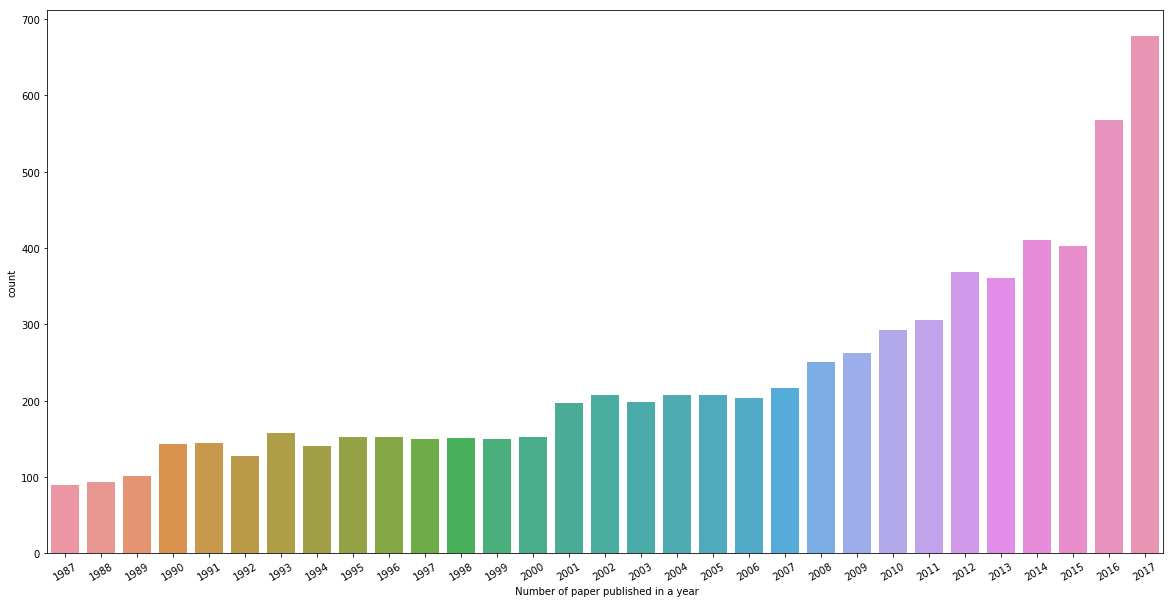

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x='year',data=data_df)
plt.xlabel(" Number of paper published in a year")
plt.xticks(rotation = 30)

* As we see from the graph as the year increases the number of research paper increases too 

In [18]:
plt.figure(figsize=(16,10))
sns.distplot(data_df['word_count_pre'],color='red')
sns.distplot(data_df['word_count_post'])
plt.xlabel(" Word count")
plt.ylabel('Frequency')
plt.xlim([0,10000])
plt.legend(['word_count_pre','word_count_post'],loc='best')

KeyError: 'word_count_pre'

<Figure size 1152x720 with 0 Axes>

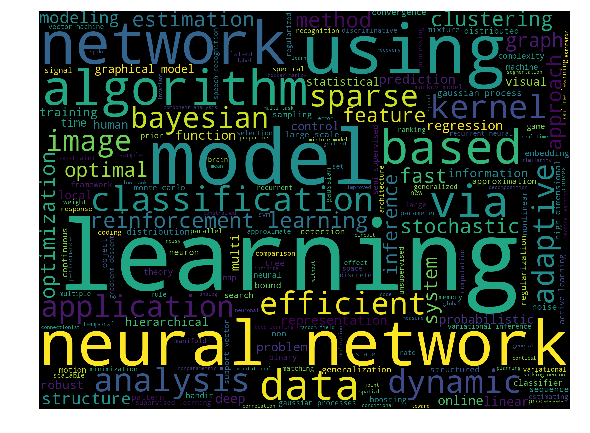

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [19]:
wordcloud_cluster(data_df,'title')

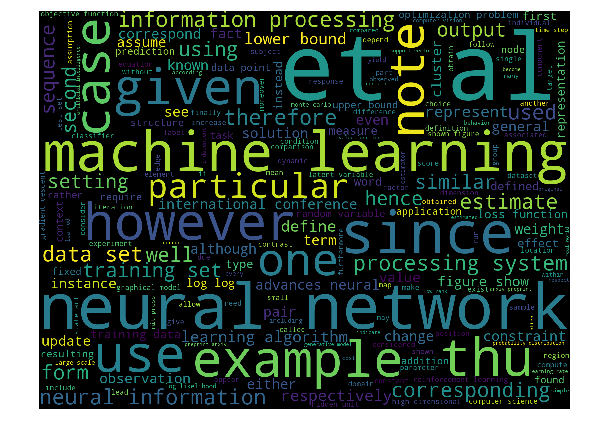

<module 'matplotlib.pyplot' from '/home/anish/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [20]:
wordcloud_cluster(data_df,'text')

* As seen from above wordcloud, title has more keywords than whole text as in text there are more part of speech tag and hence we can see the noun verb and more adjective   

In [21]:
data_df.head()

,id,year,title,text,sent_count_post,author_name
0,1,1987,self-organization of associative database and ...,self organization of associative database and...,339,Hisashi Suzuki
1,10,1987,a mean field theory of layer iv of visual cort...,mean field theory of layer iv of visual corte...,173,David Brady
2,100,1988,storing covariance by the associative long-ter...,storing covariance by the associative long te...,383,Santosh S. Venkatesh
3,1000,1994,bayesian query construction for neural network...,bayesian query construction for neural network...,256,Charles Fefferman
4,1001,1994,"neural network ensembles, cross validation, an...","neural network ensembles, cross validation, an...",233,Scott Markel


# 4.Creating Word vector  and intializing models

In [22]:
NO_FEAT  = 5000
NO_TOPIC=7
# LDA can only use raw term counts  because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_features=NO_FEAT,stop_words='english',min_df=10)
X_tf = tf_vectorizer.fit_transform(data_df['text'])
tf_feat_name = tf_vectorizer.get_feature_names()

In [17]:
lda_model = LatentDirichletAllocation(learning_method='online',random_state=23,n_components=NO_TOPIC)
lda_output =lda_model.fit_transform(X_tf)

In [310]:
pyLDAvis.sklearn.prepare(lda_model, X_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.154938  0.036239       1        1  20.341988
3      0.057564  0.000010       2        1  16.966501
0      0.055086 -0.092248       3        1  15.134433
5      0.057596  0.012325       4        1  10.879356
7     -0.058729  0.010603       5        1  10.874275
6     -0.161145  0.131246       6        1   9.312283
4      0.022941  0.052500       7        1   8.586037
2     -0.128251 -0.150675       8        1   7.905126, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
2923  Default   77224.000000         network   77224.000000  30.0000  30.0000
2080  Default   49329.000000           image   49329.000000  29.0000  29.0000
2669  Default   54029.000000          matrix   54029.000000  28.0000  28.0000
2798  Default  154699.000000           model  154699.000000  27.0000  27.0000
4253  Default   46467.000000           state   46467.000000  26.0000  26.0000
3011  Default   21878.000000          object   21878.000000  25.0000  25.0000
2927  Default   23684.000000          neuron   23684.000000  24.0000  24.0000
4572  Default   46618.000000        training   46618.000000  23.0000  23.0000
3313  Default   20001.000000          policy   20001.000000  22.0000  22.0000
1626  Default   50117.000000         feature   50117.000000  21.0000  21.0000
494   Default   38194.000000           bound   38194.000000  20.0000  20.0000
2458  Default   24437.000000           layer   24437.000000  19.0000  19.0000
2924  Default   45910.000000          neural   45910.000000  18.0000  18.0000
2476  Default  106419.000000        learning  106419.000000  17.0000  17.0000
54    Default   18895.000000          action   18895.000000  16.0000  16.0000
1040  Default   94713.000000            data   94713.000000  15.0000  15.0000
2200  Default   42722.000000           input   42722.000000  14.0000  14.0000
4497  Default   26326.000000         theorem   26326.000000  13.0000  13.0000
2370  Default   31736.000000          kernel   31736.000000  12.0000  12.0000
1251  Default   60455.000000    distribution   60455.000000  11.0000  11.0000
146   Default  115242.000000       algorithm  115242.000000  10.0000  10.0000
3811  Default   12222.000000          reward   12222.000000   9.0000   9.0000
2423  Default   20477.000000           label   20477.000000   8.0000   8.0000
2172  Default   21158.000000       inference   21158.000000   7.0000   7.0000
4685  Default   21565.000000            unit   21565.000000   6.0000   6.0000
4523  Default   69568.000000            time   69568.000000   5.0000   5.0000
4187  Default   16683.000000          sparse   16683.000000   4.0000   4.0000
683   Default   22082.000000  classification   22082.000000   3.0000   3.0000
603   Default   13602.000000            cell   13602.000000   2.0000   2.0000
4215  Default   11220.000000           spike   11220.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
738    Topic8    3141.013708           color    3776.729091   2.3533  -5.8918
1725   Topic8    4507.998745           frame    5626.631566   2.3160  -5.5305
2015   Topic8    7520.382550           human   10718.511234   2.1833  -5.0188
4040   Topic8    4636.685834           shape    6220.424890   2.2438  -5.5024
1151   Topic8    5888.572508       detection    8215.695638   2.2046  -5.2634
899    Topic8    1594.253481         contour    1868.266636   2.3791  -6.5700
4796   Topic8    7366.132025          visual   12117.681595   2.0399  -5.0395
4470   Topic8    1957.543189        template    2434.190975   2.3197  -6.3647
589    Topic8    3895.304816        category    6342.384735   2.0502  -5.6766
2833   Topic8    4139.104646          motion    6937.449934   2.0212  -5.6159
3972   Topic8    2809.073607         segment    4173.009673   2

In [18]:
pyLDAvis.sklearn.prepare(lda_model, X_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.159879 -0.052405       1        1  19.721492
3     -0.052649 -0.004501       2        1  17.756165
0     -0.066372  0.079197       3        1  16.163696
5     -0.012051 -0.061339       4        1  13.507875
2      0.103162  0.138992       5        1  12.620035
6      0.178864 -0.103242       6        1  10.324719
4      0.008926  0.003297       7        1   9.906017, topic_info=     Category           Freq            Term          Total  loglift  logprob
term                                                                         
2080  Default   47555.000000           image   47555.000000  30.0000  30.0000
2798  Default  153799.000000           model  153799.000000  29.0000  29.0000
2669  Default   53787.000000          matrix   53787.000000  28.0000  28.0000
4253  Default   46419.000000           state   46419.000000  27.0000  27.0000
2923  Default   80399.000000         network   80399.000000  26.0000  26.0000
2927  Default   23626.000000          neuron   23626.000000  25.0000  25.0000
494   Default   37906.000000           bound   37906.000000  24.0000  24.0000
3313  Default   19907.000000          policy   19907.000000  23.0000  23.0000
2370  Default   31894.000000          kernel   31894.000000  22.0000  22.0000
54    Default   18774.000000          action   18774.000000  21.0000  21.0000
1626  Default   49693.000000         feature   49693.000000  20.0000  20.0000
4497  Default   26120.000000         theorem   26120.000000  19.0000  19.0000
3011  Default   21114.000000          object   21114.000000  18.0000  18.0000
1040  Default   94932.000000            data   94932.000000  17.0000  17.0000
2458  Default   24881.000000           layer   24881.000000  16.0000  16.0000
146   Default  115026.000000       algorithm  115026.000000  15.0000  15.0000
4572  Default   47259.000000        training   47259.000000  14.0000  14.0000
1251  Default   60231.000000    distribution   60231.000000  13.0000  13.0000
2476  Default  107371.000000        learning  107371.000000  12.0000  12.0000
2560  Default   42693.000000             log   42693.000000  11.0000  11.0000
2172  Default   21057.000000       inference   21057.000000  10.0000  10.0000
4523  Default   69618.000000            time   69618.000000   9.0000   9.0000
2200  Default   43859.000000           input   43859.000000   8.0000   8.0000
3811  Default   12164.000000          reward   12164.000000   7.0000   7.0000
2423  Default   20548.000000           label   20548.000000   6.0000   6.0000
683   Default   22190.000000  classification   22190.000000   5.0000   5.0000
2924  Default   46977.000000          neural   46977.000000   4.0000   4.0000
603   Default   13496.000000            cell   13496.000000   3.0000   3.0000
4215  Default   11126.000000           spike   11126.000000   2.0000   2.0000
685   Default   15756.000000      classifier   15756.000000   1.0000   1.0000
...       ...            ...             ...            ...      ...      ...
1449   Topic7    2588.166704     equilibrium    3114.940592   2.1268  -6.3111
1542   Topic7    4421.691416          expert    5694.004149   2.0591  -5.7755
1436   Topic7    4266.879281     environment    5575.054181   2.0446  -5.8111
4457   Topic7    1784.369804              td    2088.477745   2.1547  -6.6830
4588   Topic7    5208.888828      transition    8254.653333   1.8516  -5.6117
908    Topic7    7487.310032         control   13228.287651   1.7429  -5.2488
1065   Topic7    6975.720911        decision   12512.143426   1.7278  -5.3196
374    Topic7    3543.237612          bandit    5173.558834   1.9335  -5.9970
4238   Topic7    5445.210616              st    9980.942355   1.7061  -5.5673
4291   Topic7    5376.800908        strategy   10189.255778   1.6728  -5.5799
3837   Topic7    2290.810801              rl    3054.010330   2.0245  -6.4331
2476   Topic7   25520.977408        lea

# 5. Cluster visualization and correlations. 

In [20]:
topic_lda =visualizing_topic_cluster(lda_model,10,tf_feat_name)

In [21]:
len([print('Topic'+str(key),topic_lda[key]) for key in topic_lda])

Topic0 ['data', 'learning', 'set', 'kernel', 'feature', 'method', 'training', 'label', 'algorithm', 'classification']
Topic1 ['algorithm', 'bound', 'function', 'problem', 'theorem', 'log', 'let', 'set', 'result', 'optimization']
Topic2 ['image', 'network', 'model', 'layer', 'object', 'training', 'feature', 'learning', 'neural', 'using']
Topic3 ['model', 'distribution', 'data', 'variable', 'parameter', 'inference', 'log', 'probability', 'process', 'likelihood']
Topic4 ['state', 'learning', 'policy', 'time', 'action', 'value', 'reward', 'function', 'algorithm', 'model']
Topic5 ['matrix', 'network', 'error', 'vector', 'data', 'function', 'method', 'linear', 'algorithm', 'sparse']
Topic6 ['neuron', 'model', 'network', 'time', 'input', 'neural', 'cell', 'figure', 'response', 'spike']


7

In [83]:
columns=['Topic'+ i for i in list(map(str,list(topic_lda.keys())))]

In [88]:
lda_df =pd.DataFrame(lda_output,columns=columns).apply(lambda x : np.round(x,3))

In [89]:
lda_df['Major_topic'] =lda_df[columns].idxmax(axis=1).apply(lambda x: int(x[-1]))

In [90]:
lda_df['keyword'] = lda_df['Major_topic'].apply(lambda x: topic_lda[x])

In [91]:
lda_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Major_topic,keyword
0,0.083,0.123,0.258,0.015,0.230,0.127,0.163,2,"[image, network, model, layer, object, trainin..."
1,0.000,0.021,0.000,0.009,0.003,0.096,0.871,6,"[neuron, model, network, time, input, neural, ..."
2,0.000,0.009,0.000,0.000,0.000,0.010,0.981,6,"[neuron, model, network, time, input, neural, ..."
3,0.265,0.000,0.000,0.311,0.144,0.262,0.018,3,"[model, distribution, data, variable, paramete..."
4,0.503,0.000,0.000,0.000,0.000,0.473,0.023,0,"[data, learning, set, kernel, feature, method,..."


Text(0.5, 1.0, ' Correlation Plot')

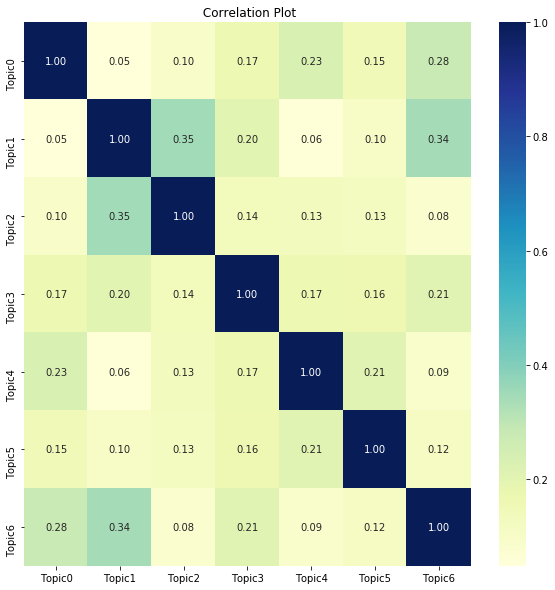

In [189]:
plt.figure(figsize=(10,10))
sns.heatmap(abs(lda_df[columns].corr()),annot=True,fmt ='0.2f',cmap="YlGnBu")
plt.title(" Correlation Plot")

From the above correlation graph we can see that,the topic clusters are not correlated.

In [92]:
data_df.reset_index(inplace=True)

In [93]:
data_df.shape,lda_df.shape

((7238, 9), (7238, 9))

In [94]:
df_total =pd.concat(objs=(lda_df,data_df[['id','title']]),axis=1)

In [95]:
df_total.shape

(7238, 11)

# 6. t-SNE  2D Visualization

In [96]:
tsne_model = TSNE(n_components=2,random_state=23)

In [97]:
vect_2D = tsne_model.fit_transform(X_tf.todense())

In [98]:
x_cor_2d=[]
y_cor_2d=[]
for x,y in vect_2D:
    x_cor_2d.append(x)
    y_cor_2d.append(y)

In [99]:
topic_no =list(lda_df['Major_topic'])

(-74.95665393711761, 95.18413196446134, -88.80827484641733, 73.65290222678843)

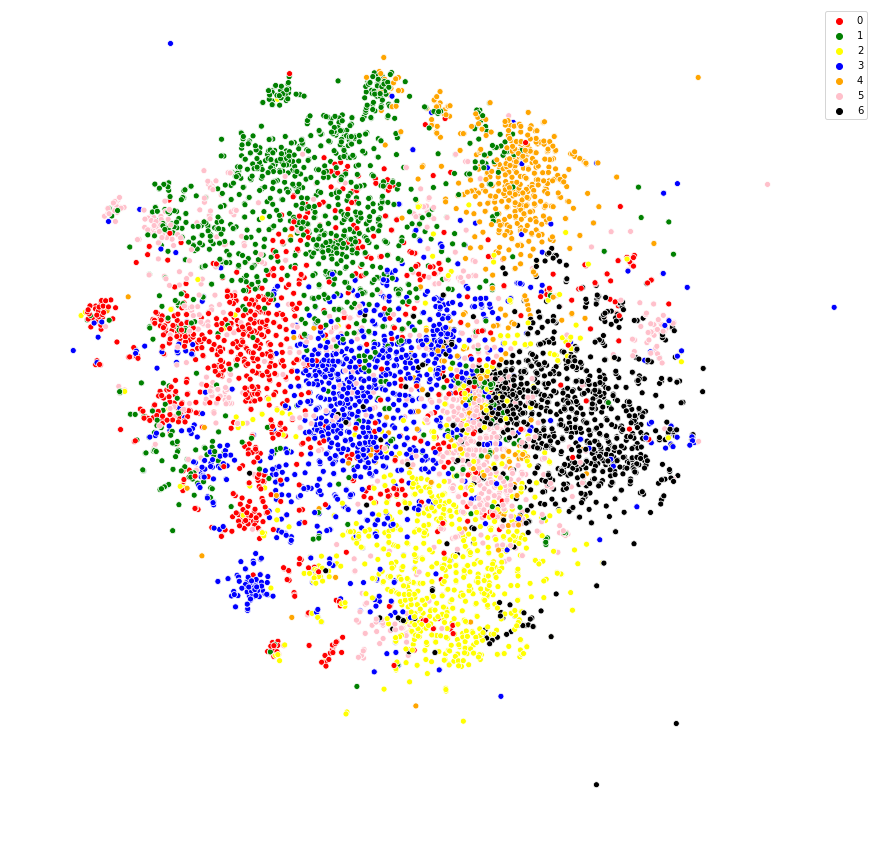

In [100]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=x_cor_2d,y=y_cor_2d,hue=topic_no,palette=['red','green','yellow','blue','orange','pink','black'])
plt.axis('off')

# 7.Tensorboard 3D vizualization  

In [101]:
feature_df =pd.DataFrame(X_tf.toarray())

In [102]:
feature_df.shape

(7238, 5000)

In [103]:
labels =list(lda_df['Major_topic'])

In [104]:
len(labels)

7238

In [105]:
# Path to save the embedding and checkpoints generated
LOG_DIR = 'log_file'

In [106]:
metadata = os.path.join(LOG_DIR, 'labels.tsv')

In [107]:
metadata

'log_file/labels.tsv'

In [108]:
with open(metadata, 'w') as metadata_file:
    for row in labels:
        metadata_file.write('%d\n' % row)

In [109]:
## TensorFlow Variable 
feature = tf.Variable(feature_df,name='feature')

In [110]:
with tf.Session() as sess:
    saver = tf.train.Saver([feature])

    sess.run(feature.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'feature'))   
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = feature.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

# 8.Reccomendation System 

# 9.Results: 

In [117]:
reccomendation(df_total,1434,columns)

 The title  of selected paper is  :  hybrid reinforcement learning and its application to biped robot control
 Major Topic --- 4
------------------------------------------------------------------------------------------------------------------------
 The  keywords which is highlighted in this topic are as follows : 
['state', 'learning', 'policy', 'time', 'action', 'value', 'reward', 'function', 'algorithm', 'model']
------------------------------------------------------------------------------------------------------------------------
 The Recommended topic are as follows: 
1 ... intrinsically motivated reinforcement learning --- 
      Error  is  ... 0.000694
2 ... low power wireless communication via reinforcement learning --- 
      Error  is  ... 0.000714
3 ... learning by state recurrence detection --- 
      Error  is  ... 0.000846
4 ... learning to use working memory in partially observable environments through dopaminergic reinforcement --- 
      Error  is  ... 0.000942
5 ...

In [114]:
reccomendation(df_total,1007,columns)

 The title  of selected paper is  :  learning to play the game of chess
 Major Topic --- 4
------------------------------------------------------------------------------------------------------------------------
 The  keywords which is highlighted in this topic are as follows : 
['state', 'learning', 'policy', 'time', 'action', 'value', 'reward', 'function', 'algorithm', 'model']
------------------------------------------------------------------------------------------------------------------------
 The Recommended topic are as follows: 
1 ... natural value approximators: learning when to trust past estimates --- 
      Error  is  ... 0.000899
2 ... active exploration in dynamic environments --- 
      Error  is  ... 0.00096
3 ... hybrid reward architecture for reinforcement learning --- 
      Error  is  ... 0.000986
4 ... planning with an adaptive world model --- 
      Error  is  ... 0.001063
5 ... thinking fast and slow with deep learning and tree search --- 
      Error  is  ... 0

In [113]:
reccomendation(df_total,174,columns)

 The title  of selected paper is  :  speech recognition: statistical and neural information processing approaches
 Major Topic --- 2
------------------------------------------------------------------------------------------------------------------------
 The  keywords which is highlighted in this topic are as follows : 
['image', 'network', 'model', 'layer', 'object', 'training', 'feature', 'learning', 'neural', 'using']
------------------------------------------------------------------------------------------------------------------------
 The Recommended topic are as follows: 
1 ... phoneme recognition with large hierarchical reservoirs --- 
      Error  is  ... 0.0005
2 ... evaluation of adaptive mixtures of competing experts --- 
      Error  is  ... 0.001273
3 ... learning to make coherent predictions in domains with discontinuities --- 
      Error  is  ... 0.001292
4 ... speaker independent speech recognition with neural networks and speech knowledge --- 
      Error  is  ... 0.

# 10. Evaluations: 

In [166]:
topic_actual,topic_pred = eval_metrics(df_total,columns)

 The accuracy score is : 0.7554290863000619
...........................................................................................................................
 The classification report 
             precision    recall  f1-score   support

          0       0.74      0.71      0.73   1255573
          1       0.75      0.78      0.77   1706082
          2       0.79      0.76      0.77    825672
          3       0.76      0.78      0.77   1579759
          4       0.75      0.71      0.73    453650
          5       0.66      0.61      0.63    971672
          6       0.84      0.87      0.86   1012036

avg / total       0.75      0.76      0.75   7804444



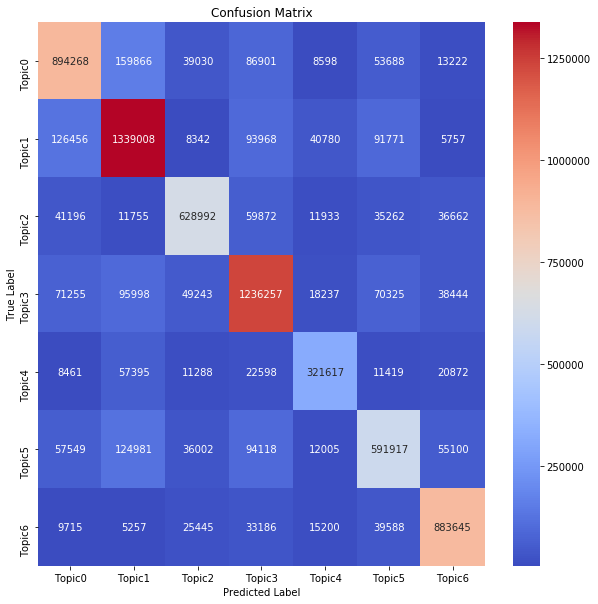

In [200]:
confusion_matrix_plot(topic_actual,topic_pred,columns)

# 11. Summary:
* At first,we will import libraires and  processed dataset
* Removing the missing values
* Count plot of the research paper publish per year, we see that as  year increases the number of research paper published also increased.
* We observed that number of words decreases before and after the word processing.On average the  number of word before text processing was nearly 4000 words to 6000 words.After the word processing the word count decreases
* Creating the word clould of the title and documents we see that title word cloud consists of more technial terms where as when we take the whole text then we found that many Part Of Speech(POS) are also included in the word cloud.
* Creating a word vector using CountVectorizer and trying to find the optimal  number of clusters using pyLDAvis.
* Creating the LDA model as per the cluster  visualization and fitting the data into the model.
*  when we do correlation between the topics we found that most of the topics are not correlated,it means that the words present in a certain cluster has minimal chances to be found in another clusters.
* Visualizing word cluster in a t-SNE visualization using  tensorboard.
* Creating the reccomendation function based on root mean square error and printing the recommended title  with the error.
* Evaluating the reccomendation system based on Major topic classification.When the topics is fragmented ionto different cluster then there is a slight error because it evaluted the topic only on major topic classification, but overall acuuracy acore is 75%.